In [18]:
# Initial setup:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1

#For fancy plots
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

import numpy as np

from scipy.stats import chi2, multivariate_normal
from scipy.special import erfinv
from scipy.linalg import sqrtm, inv

import getdist
from getdist import plots, MCSamples
getdist.chains.print_load_details = False

import git
import sys, os

# Create the two toy chains and the joint chain:
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
path_global = os.path.dirname(path_git)
print('Path to git repo: {}'.format(path_global))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Path to git repo: /home/matias/Documents/PhD/code


# Three moltivariate distributions

In [19]:
#Fixed Parameters
#num_parameters = 2
#num_datasets = 3

#Sharp triangle
mean_A = np.array([-1/2., 0.]) 
mean_B = np.array([1/2, 0.])
mean_C = np.array([0, np.sqrt(3)/2.])

cov_A = np.array([[1, 0.], [0., 1]])
cov_B = cov_A.copy()
cov_C = cov_A.copy()



In [20]:
#Define some functions:

def calculate_R_CM(vectors):
    num_vectors = len(vectors)
    R_CM = np.sum(vectors, axis=0) / num_vectors
    return R_CM

def construct_K(vectors):
    num_vectors = len(vectors)

    R_CM = calculate_R_CM(vectors)

    K_xx = np.sum((vectors[:, 0] - R_CM[0]) ** 2)
    K_yy = np.sum((vectors[:, 1] - R_CM[1]) ** 2)
    K_xy = np.sum((vectors[:, 0] - R_CM[0]) * (vectors[:, 1] - R_CM[1]))
    K_yx = K_xy
    K = np.array([[K_xx, K_xy], [K_yx, K_yy]])
    return K


'''
def compute_inertia_tensor_cm(positions, masses):
    """
    Compute the inertia tensor relative to the center of mass (CM).
    
    Parameters:
    positions : np.ndarray
        Array of shape (N, 3) containing the positions of N particles.
    masses : np.ndarray
        Array of shape (N,) containing the masses of the N particles.
    
    Returns:
    I_cm : np.ndarray
        The 3x3 inertia tensor relative to the center of mass.
    """
    # Compute the total mass
    M = np.sum(masses)
    
    # Compute the center of mass
    R_cm = np.sum(masses[:, np.newaxis] * positions, axis=0) / M
    
    # Compute the positions relative to the center of mass
    rel_positions = positions - R_cm
    
    # Initialize the inertia tensor
    I_cm = np.zeros((2, 2))
    
    # Compute the inertia tensor relative to CM
    for i in range(len(masses)):
        m = masses[i]
        x, y = rel_positions[i]
        
        I_cm[0, 0] += m * (y**2)
        I_cm[1, 1] += m * (x**2)
        
        I_cm[0, 1] -= m * x * y
    
    # Exploit symmetry: I_ji = I_ij
    I_cm[1, 0] = I_cm[0, 1]
    
    return I_cm
'''

'\ndef compute_inertia_tensor_cm(positions, masses):\n    """\n    Compute the inertia tensor relative to the center of mass (CM).\n    \n    Parameters:\n    positions : np.ndarray\n        Array of shape (N, 3) containing the positions of N particles.\n    masses : np.ndarray\n        Array of shape (N,) containing the masses of the N particles.\n    \n    Returns:\n    I_cm : np.ndarray\n        The 3x3 inertia tensor relative to the center of mass.\n    """\n    # Compute the total mass\n    M = np.sum(masses)\n    \n    # Compute the center of mass\n    R_cm = np.sum(masses[:, np.newaxis] * positions, axis=0) / M\n    \n    # Compute the positions relative to the center of mass\n    rel_positions = positions - R_cm\n    \n    # Initialize the inertia tensor\n    I_cm = np.zeros((2, 2))\n    \n    # Compute the inertia tensor relative to CM\n    for i in range(len(masses)):\n        m = masses[i]\n        x, y = rel_positions[i]\n        \n        I_cm[0, 0] += m * (y**2)\n        


For conviencience we will name the pairs as:

* 1: AB
* 2: AC
* 3: BC

## Tension vectors
$$\vec{r}_{1}=\frac{1}{\sqrt{C_{A}+C_{B}}}(\vec{\bar{\theta}}_{A}-\vec{\bar{\theta}}_{B}) $$
$$\vec{r}_{2}=\frac{1}{\sqrt{C_{A}+C_{C}}}(\vec{\bar{\theta}}_{A}-\vec{\bar{\theta}}_{C}) $$
$$\vec{r}_{3}=\frac{1}{\sqrt{C_{B}+C_{C}}}(\vec{\bar{\theta}}_{B}-\vec{\bar{\theta}}_{C}) $$

In general, if we have N datasets, the total number tension vectors is 

$$L=\frac{N^2-N}{2}=\frac{N(N-1)}{2}$$

## Center of Mass

$$\vec{R}_{CM} = \frac{\sum_i m_{i} \vec{r}_{i}}{\sum_i m_{i}} \, ,$$

where $m_{i}=1$.

## Mass Dispertion Tensor

$$K_{ij} = \sum_{k=\{1, 2, 3\}} m_{k} (\vec{r}^{i}_{k}-\vec{R}^{i}_{CM}) (\vec{r}^{j}_{k}-\vec{R}^{j}_{CM})$$

$$\mathcal{C}_{ij} = \frac{K_{ij}}{\sum_i m_{i}} \, ,$$

## Inertia Tensor

$$I_{ij} = \sum_{k=\{1, 2, 3\}} m_{k} [\delta_{ij}|\vec{r}_{k}-\vec{R}_{CM}|^{2}-(\vec{r}^{i}_{k}-\vec{R}^{i}_{CM}) (\vec{r}^{j}_{k}-\vec{R}^{j}_{CM})]$$



In [21]:
r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))

# Example usage:
vectors = np.array([r_1, r_2, r_3])
R_CM = calculate_R_CM(vectors)
print('Center of mass: {}'.format(R_CM))

# Example usage:
K = construct_K(vectors)
print('Tensor of Inertia: {}'.format(K))

#I = compute_inertia_tensor_cm(vectors, np.ones(3))
#print('Tensor of Inertia: {}'.format(I))

eigenvalues, eigenvectors = np.linalg.eig(K)
print('Eigenvalues: {}'.format(eigenvalues))
print('Eigenvectors: {}'.format(eigenvectors))
print('The volume of the ellipsoid is given by the square root of the determinant of K: {}'.format(np.sqrt(np.linalg.det(K))))

Center of mass: [-0.23570226 -0.40824829]
Tensor of Inertia: [[ 0.58333333 -0.28867513]
 [-0.28867513  0.25      ]]
Eigenvalues: [0.75       0.08333333]
Eigenvectors: [[ 0.8660254  0.5      ]
 [-0.5        0.8660254]]
The volume of the ellipsoid is given by the square root of the determinant of K: 0.25


Plot this information:

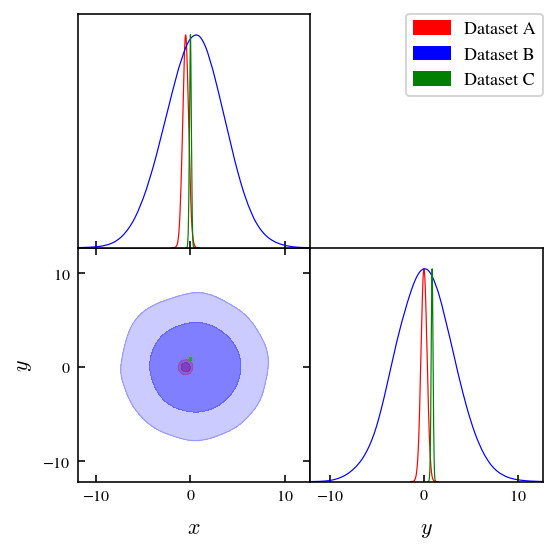

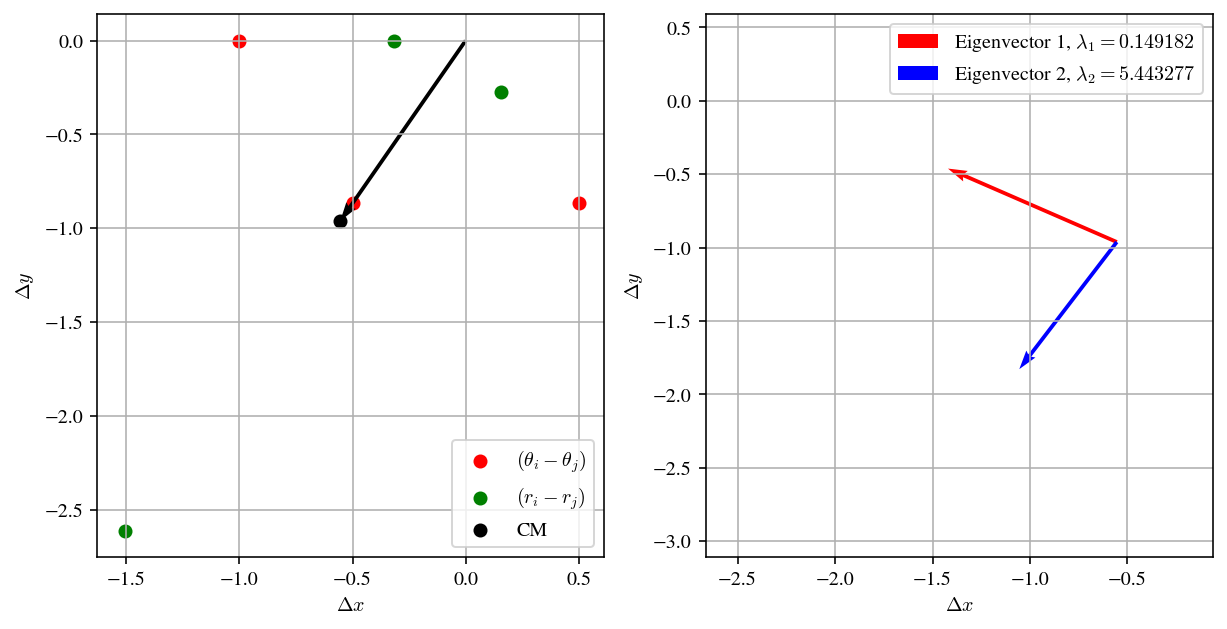

In [22]:
#Sharp triangle
mean_A = np.array([-1/2., 0.]) 
mean_B = np.array([1/2, 0.])
mean_C = np.array([0, np.sqrt(3)/2.])

cov_A = np.array([[1, 0.], [0., 1]])/10
cov_B = cov_A.copy()*100
cov_C = cov_A.copy()/10

r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))

# Example usage:
vectors = np.array([r_1, r_2, r_3])
R_CM = calculate_R_CM(vectors)
K = construct_K(vectors)
eigenvalues, eigenvectors = np.linalg.eig(K)

samps_A = np.random.multivariate_normal(mean_A, cov_A, size=10000)
samps_B = np.random.multivariate_normal(mean_B, cov_B, size=10000)
samps_C = np.random.multivariate_normal(mean_C, cov_C, size=10000)

names = ['x', 'y']
labels = ['x', 'y']

chain_A = MCSamples(samples=samps_A, names=names, labels=labels, label='Dataset A')
chain_B = MCSamples(samples=samps_B, names=names, labels=labels, label='Dataset B')
chain_C = MCSamples(samples=samps_C, names=names, labels=labels, label='Dataset C')

colors = ['red', 'blue', 'green']

g = plots.get_subplot_plotter()
g.triangle_plot([chain_A, chain_B, chain_C],\
                filled=True, contour_args={'alpha':0.5},\
                contour_colors=colors)
os.chdir(os.path.join(path_git, 'docs', 'example_notebooks', 'paper','PRL', 'figures'))
g.export('dist_1.png')

fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].scatter([(mean_A - mean_B)[0], (mean_A - mean_C)[0], (mean_B - mean_C)[0]], [(mean_A - mean_B)[1], (mean_A - mean_C)[1], (mean_B - mean_C)[1]],\
                 color='red', label=r'$(\theta_{i} - \theta_{j})$')
axes[0].quiver(0, 0, R_CM[0], R_CM[1], angles='xy', scale_units='xy', scale=1, color='k')
axes[0].scatter([r_1[0], r_2[0], r_3[0]], [r_1[1], r_2[1], r_3[1]], color='green', label=r'$(r_{i} - r_{j})$')
axes[0].scatter([R_CM[0]], [R_CM[1]], color='black', label='CM')

axes[1].quiver(R_CM[0], R_CM[1], eigenvectors[0, 0], eigenvectors[1, 0], angles='xy', scale_units='xy', scale=1, color='r', label=r'Eigenvector 1, $\lambda_1={:2f}$'.format(eigenvalues[0]))
axes[1].quiver(R_CM[0], R_CM[1], eigenvectors[0, 1], eigenvectors[1, 1], angles='xy', scale_units='xy', scale=1, color='b', label=r'Eigenvector 2, $\lambda_2={:2f}$'.format(eigenvalues[1]))
x_min, x_max = (R_CM[0] + eigenvectors[0, :]).min()-1, (R_CM[0] + eigenvectors[0, :]).max()+1
y_min, y_max = (R_CM[1] + eigenvectors[1, :]).min()-1, (R_CM[1] + eigenvectors[1, :]).max()+1
axes[1].set_xlim(1.1 * x_min, 1.1 * x_max)
axes[1].set_ylim(1.1 * y_min, 1.1 * y_max)

for ax in axes.flatten():
    ax.set_xlabel(r'$\Delta x$')
    ax.set_ylabel(r'$\Delta y$')
    ax.grid()
    ax.legend()
os.chdir(os.path.join(path_git, 'docs', 'example_notebooks', 'paper','PRL', 'figures'))
fig.savefig('tension_1.png', dpi=300, bbox_inches='tight')
plt.show()

Other examples:

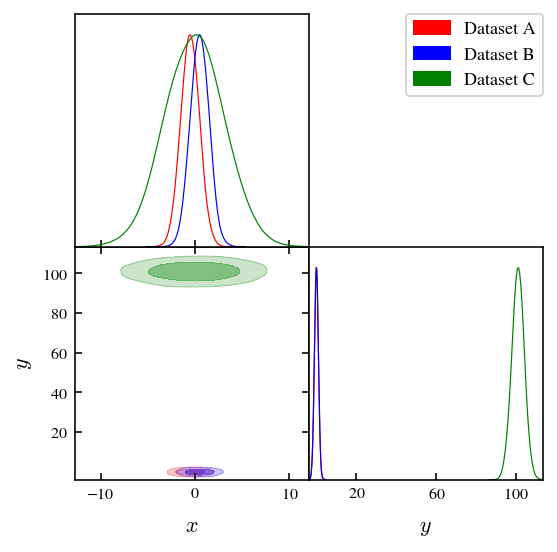

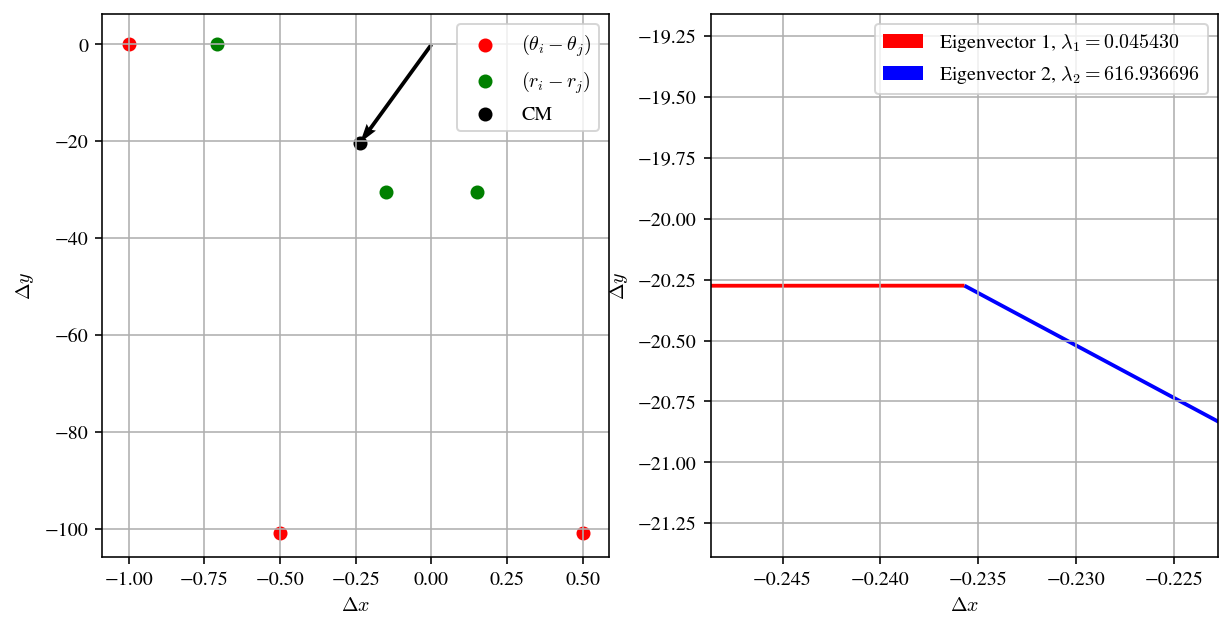

In [23]:
mean_A = np.array([-1/2., 0.]) 
mean_B = np.array([1/2, 0.])
mean_C = np.array([0, 100+np.sqrt(3)/2.])

cov_A = np.array([[1, 0.], [0., 1]])
cov_B = cov_A.copy()
cov_C = cov_A.copy()*10

r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))


vectors = np.array([r_1, r_2, r_3])
R_CM = calculate_R_CM(vectors)
K = construct_K(vectors)
eigenvalues, eigenvectors = np.linalg.eig(K)

samps_A = np.random.multivariate_normal(mean_A, cov_A, size=10000)
samps_B = np.random.multivariate_normal(mean_B, cov_B, size=10000)
samps_C = np.random.multivariate_normal(mean_C, cov_C, size=10000)

names = ['x', 'y']
labels = ['x', 'y']

chain_A = MCSamples(samples=samps_A, names=names, labels=labels, label='Dataset A')
chain_B = MCSamples(samples=samps_B, names=names, labels=labels, label='Dataset B')
chain_C = MCSamples(samples=samps_C, names=names, labels=labels, label='Dataset C')

colors = ['red', 'blue', 'green']

g = plots.get_subplot_plotter()
g.triangle_plot([chain_A, chain_B, chain_C],\
                filled=True, contour_args={'alpha':0.5},\
                contour_colors=colors)
os.chdir(os.path.join(path_git, 'docs', 'example_notebooks', 'paper','PRL', 'figures'))
g.export('dist_2.png')

fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].scatter([(mean_A - mean_B)[0], (mean_A - mean_C)[0], (mean_B - mean_C)[0]], [(mean_A - mean_B)[1], (mean_A - mean_C)[1], (mean_B - mean_C)[1]],\
                 color='red', label=r'$(\theta_{i} - \theta_{j})$')
axes[0].quiver(0, 0, R_CM[0], R_CM[1], angles='xy', scale_units='xy', scale=1, color='k')
axes[0].scatter([r_1[0], r_2[0], r_3[0]], [r_1[1], r_2[1], r_3[1]], color='green', label=r'$(r_{i} - r_{j})$')
axes[0].scatter([R_CM[0]], [R_CM[1]], color='black', label='CM')

axes[1].quiver(R_CM[0], R_CM[1], eigenvectors[0, 0], eigenvectors[1, 0], angles='xy', scale_units='xy', scale=1, color='r', label=r'Eigenvector 1, $\lambda_1={:2f}$'.format(eigenvalues[0]))
axes[1].quiver(R_CM[0], R_CM[1], eigenvectors[0, 1], eigenvectors[1, 1], angles='xy', scale_units='xy', scale=1, color='b', label=r'Eigenvector 2, $\lambda_2={:2f}$'.format(eigenvalues[1]))
#x_min, x_max = (R_CM[0] + eigenvectors[0, :]).min()-1, (R_CM[0] + eigenvectors[0, :]).max()+1
#y_min, y_max = (R_CM[1] + eigenvectors[1, :]).min()-1, (R_CM[1] + eigenvectors[1, :]).max()+1
#axes[1].set_xlim(1.1 * x_min, 1.1 * x_max)
#axes[1].set_ylim(1.1 * y_min, 1.1 * y_max)

for ax in axes.flatten():
    ax.set_xlabel(r'$\Delta x$')
    ax.set_ylabel(r'$\Delta y$')
    ax.grid()
    ax.legend()
os.chdir(os.path.join(path_git, 'docs', 'example_notebooks', 'paper','PRL', 'figures'))
fig.savefig('tension_2.png', dpi=300, bbox_inches='tight')

plt.show()

In [24]:
import git
import sys, os

# Create the two toy chains and the joint chain:
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
#os.chdir(os.path.join(path_git, 'source'))
os.chdir('/home/matias/Documents/PhD/code/montepython_public_old/output')

#Fixed Parameters
#num_parameters = 2
#num_datasets = 4

'''
A: CC 
B: Planck18 
C: BAO 
D: PPS
'''

chain_A = getdist.mcsamples.loadMCSamples(file_root='lcdm_cc/2023-09-18_1000000_', no_cache=True,settings={'loglikes':True,'label':'CC','ignore_rows': '0.3'})
chain_B = getdist.mcsamples.loadMCSamples(file_root='lcdm_planck/2023-09-16_1000000_', no_cache=True,settings={'loglikes':True,'label':'Planck18','ignore_rows': '0.3'})
chain_C = getdist.mcsamples.loadMCSamples(file_root='old_metrics/lcdm_bao_plus/2024-03-07_1000000_', no_cache=True,settings={'label':'BAO','ignore_rows': '0.3'})
chain_D = getdist.mcsamples.loadMCSamples(file_root='lcdm_pps/2023-09-18_1000000_', no_cache=True,settings={'label':'PPS','ignore_rows': '0.3'})



param_names = ['Omega_m','H0'] #Shared paameters

#Estimate the mean and covariance of the chains:
mean_A = chain_A.mean(param_names)
cov_A = chain_A.cov(param_names)
mean_B = chain_B.mean(param_names)
cov_B = chain_B.cov(param_names)
mean_C = chain_C.mean(param_names)
cov_C = chain_C.cov(param_names)
mean_D = chain_D.mean(param_names)
cov_D = chain_D.cov(param_names)


Center of mass: [-1.1227663  -1.84922768]
Tensor of Inertia: [[ 9.76920602 10.79016075]
 [10.79016075 27.13784506]]
Eigenvalues: [ 4.60271421 32.30433687]
Eigenvectors: [[-0.90193956 -0.43186227]
 [ 0.43186227 -0.90193956]]


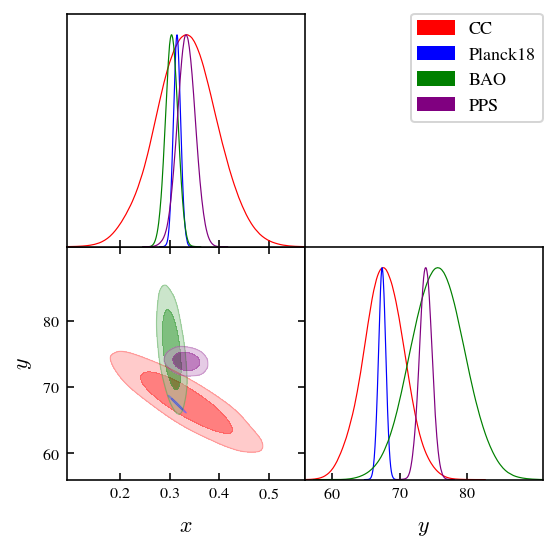

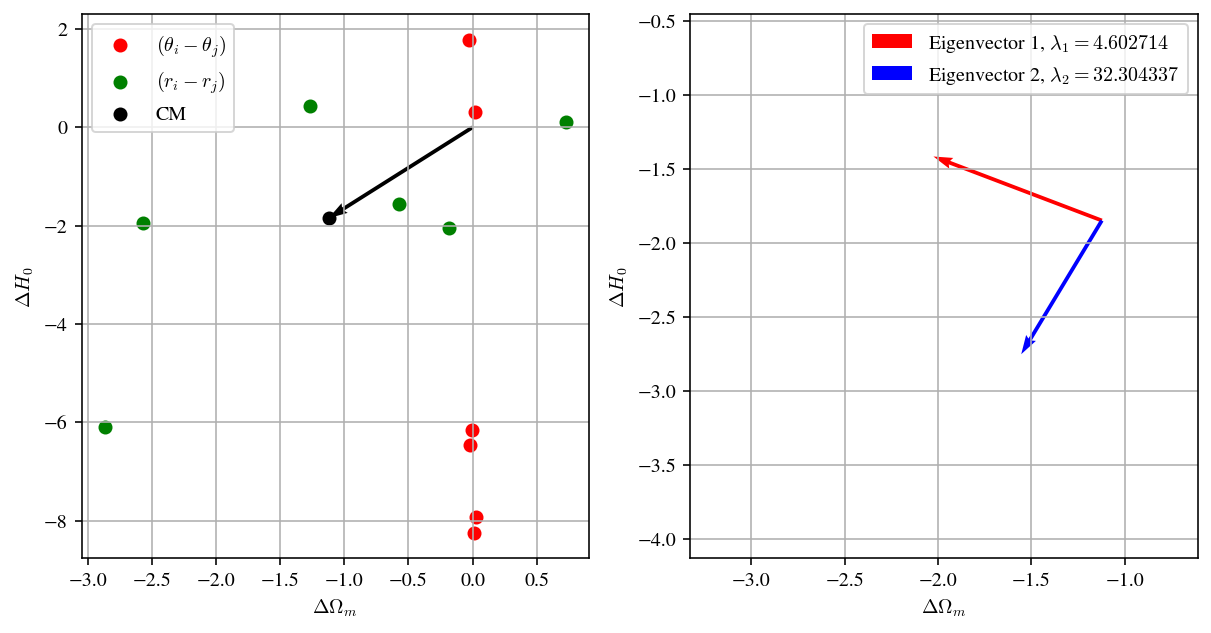

In [25]:
r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))
r_4 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_D)), (mean_A - mean_D))
r_5 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_D)), (mean_B - mean_D))
r_6 = np.dot(sqrtm(np.linalg.inv(cov_C + cov_D)), (mean_C - mean_D))


# Example usage:
vectors = np.array([r_1, r_2, r_3, r_4, r_5, r_6])
R_CM = calculate_R_CM(vectors)
print('Center of mass: {}'.format(R_CM))

# Example usage:
K = construct_K(vectors)
print('Tensor of Inertia: {}'.format(K))
eigenvalues, eigenvectors = np.linalg.eig(K)
print('Eigenvalues: {}'.format(eigenvalues))
print('Eigenvectors: {}'.format(eigenvectors))

samps_A = np.random.multivariate_normal(mean_A, cov_A, size=10000)
samps_B = np.random.multivariate_normal(mean_B, cov_B, size=10000)
samps_C = np.random.multivariate_normal(mean_C, cov_C, size=10000)
samps_D = np.random.multivariate_normal(mean_D, cov_D, size=10000)

chain_A = MCSamples(samples=samps_A, names=names, labels=labels, label='Dataset A')
chain_B = MCSamples(samples=samps_B, names=names, labels=labels, label='Dataset B')
chain_C = MCSamples(samples=samps_C, names=names, labels=labels, label='Dataset C')
chain_D = MCSamples(samples=samps_D, names=names, labels=labels, label='Dataset D')

colors = ['red', 'blue', 'green', 'purple']

g = plots.get_subplot_plotter()
g.triangle_plot([chain_A, chain_B, chain_C, chain_D],\
                filled=True, contour_args={'alpha':0.5},\
                contour_colors=colors,
                legend_labels=['CC', 'Planck18', 'BAO', 'PPS'])
os.chdir(os.path.join(path_git, 'docs', 'example_notebooks', 'paper','PRL', 'figures'))
g.export('dist_data.png')

fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].scatter([(mean_A - mean_B)[0], (mean_A - mean_C)[0], (mean_B - mean_C)[0], (mean_A - mean_D)[0], (mean_B - mean_D)[0], (mean_C - mean_D)[0]],\
                [(mean_A - mean_B)[1], (mean_A - mean_C)[1], (mean_B - mean_C)[1], (mean_A - mean_D)[1], (mean_B - mean_D)[1], (mean_C - mean_D)[1]],\
                 color='red', label=r'$(\theta_{i} - \theta_{j})$')
axes[0].quiver(0, 0, R_CM[0], R_CM[1], angles='xy', scale_units='xy', scale=1, color='k')

axes[0].scatter([r_1[0], r_2[0], r_3[0], r_4[0], r_5[0], r_6[0]], [r_1[1], r_2[1], r_3[1], r_4[1], r_5[1], r_6[1]], color='green', label=r'$(r_{i} - r_{j})$')
axes[0].scatter([R_CM[0]], [R_CM[1]], color='black', label='CM')


axes[1].quiver(R_CM[0], R_CM[1], eigenvectors[0, 0], eigenvectors[1, 0], angles='xy', scale_units='xy', scale=1, color='r', label=r'Eigenvector 1, $\lambda_1={:2f}$'.format(eigenvalues[0]))
axes[1].quiver(R_CM[0], R_CM[1], eigenvectors[0, 1], eigenvectors[1, 1], angles='xy', scale_units='xy', scale=1, color='b', label=r'Eigenvector 2, $\lambda_2={:2f}$'.format(eigenvalues[1]))
x_min, x_max = (R_CM[0] + eigenvectors[0, :]).min()-1, (R_CM[0] + eigenvectors[0, :]).max()+1
y_min, y_max = (R_CM[1] + eigenvectors[1, :]).min()-1, (R_CM[1] + eigenvectors[1, :]).max()+1
axes[1].set_xlim(1.1 * x_min, 1.1 * x_max)
axes[1].set_ylim(1.1 * y_min, 1.1 * y_max)

for ax in axes.flatten():
    ax.set_xlabel(r'$\Delta \Omega_m$')
    ax.set_ylabel(r'$\Delta H_0$')
    ax.grid()
    ax.legend()
os.chdir(os.path.join(path_git, 'docs', 'example_notebooks', 'paper','PRL', 'figures'))
fig.savefig('tension_data.png', dpi=300, bbox_inches='tight')
plt.show()

In [26]:
# Alternative form (not work properly..)
from scipy.special import erfcinv
PTE = 1-np.exp(multivariate_normal.logcdf(x=np.zeros(len(R_CM)), mean=R_CM, cov=K/len(R_CM)))
n_sigma = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'n_sigma = {n_sigma}')

PTE = 0.4243924855660668
n_sigma = 0.7988239768684556


**Obs:** Las flechas pueden estar desalineadas si ambos graficos están en escalas distintas!

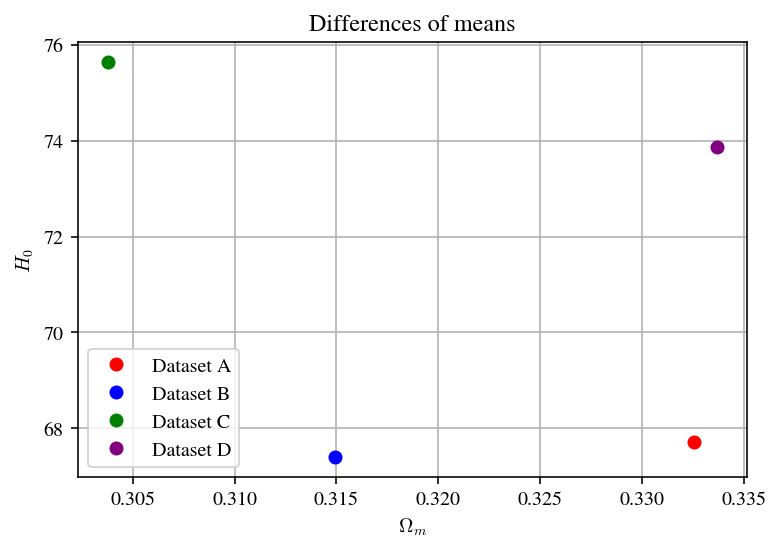

In [27]:
# Plot the  means
plt.plot(mean_A[0], mean_A[1], 'o', color='red', label='Dataset A')
plt.plot(mean_B[0], mean_B[1], 'o', color='blue', label='Dataset B')
plt.plot(mean_C[0], mean_C[1], 'o', color='green', label='Dataset C')
plt.plot(mean_D[0], mean_D[1], 'o', color='purple', label='Dataset D')
plt.grid()
plt.legend()
plt.xlabel(r'$\Omega_m$')
plt.ylabel(r'$H_0$')
plt.title('Differences of means')
plt.show()

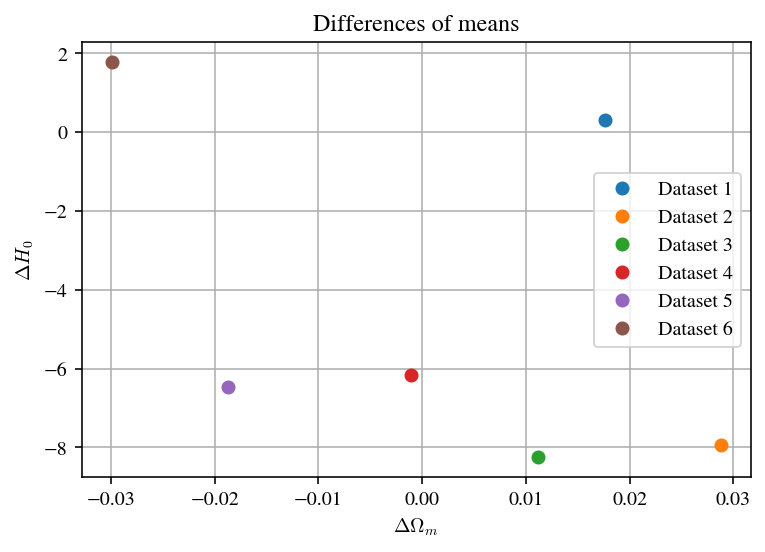

In [28]:
# Plot the differences of means
r_1 = (mean_A - mean_B)
r_2 = (mean_A - mean_C)
r_3 = (mean_B - mean_C)
r_4 = (mean_A - mean_D)
r_5 = (mean_B - mean_D)
r_6 = (mean_C - mean_D)

plt.plot(r_1[0], r_1[1], 'o', label='Dataset 1')
plt.plot(r_2[0], r_2[1], 'o', label='Dataset 2')
plt.plot(r_3[0], r_3[1], 'o', label='Dataset 3')
plt.plot(r_4[0], r_4[1], 'o', label='Dataset 4')
plt.plot(r_5[0], r_5[1], 'o', label='Dataset 5')
plt.plot(r_6[0], r_6[1], 'o', label='Dataset 6')
plt.legend()
plt.grid()
plt.xlabel(r'$\Delta \Omega_m$')
plt.ylabel(r'$\Delta H_0$')
plt.title('Differences of means')
plt.show()

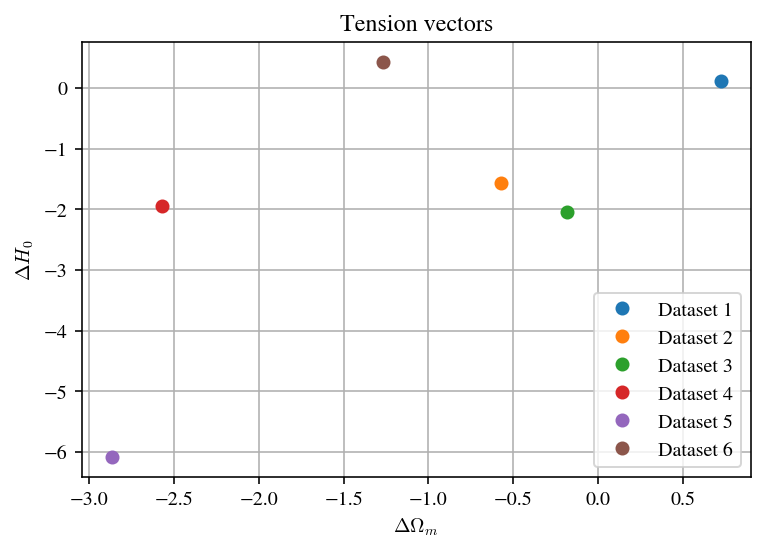

In [29]:
# Plot the tension vectors
r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))
r_4 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_D)), (mean_A - mean_D))
r_5 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_D)), (mean_B - mean_D))
r_6 = np.dot(sqrtm(np.linalg.inv(cov_C + cov_D)), (mean_C - mean_D))


plt.plot(r_1[0], r_1[1], 'o', label='Dataset 1')
plt.plot(r_2[0], r_2[1], 'o', label='Dataset 2')
plt.plot(r_3[0], r_3[1], 'o', label='Dataset 3')
plt.plot(r_4[0], r_4[1], 'o', label='Dataset 4')
plt.plot(r_5[0], r_5[1], 'o', label='Dataset 5')
plt.plot(r_6[0], r_6[1], 'o', label='Dataset 6')
plt.legend()
plt.grid()
plt.xlabel(r'$\Delta \Omega_m$')
plt.ylabel(r'$\Delta H_0$')
plt.title('Tension vectors')
plt.show()

# Cosas para charlar:

* $\vec{R}_{CM}$ es la posición del CM (idealmente $\vec{R}_{CM}$ no debe ser grande).
* $K_{ij}$ es la dispersión de particulas alrededor del CM.
* Los autovalores indican si hay alguna direccion que es despreciable (diferencia entre un cigarro o una elipse plana). Si alguno de los ejes principales de $K_{ij}$ da cero hay una relacion lineal entre todas las mediciones que da cero.
* El determinante de $K_{ij}$ da una noción del volumen del elipsoide (tal vez comparar el tamaño para distintos modelos?)
* $\mathcal{C_{ij}}=\frac{K_{ij}}{N}$ es la estimación de la matriz de covarianza de la tensión. Al muestrear esta nueva gaussiana obtenemos una lista de $Q*$ que podemos reinterpretar como un $N_{\sigma}$. De esta manera puedo construirme una distribución $N_{\sigma}$ y dar una media y una varianza para esta distribución!

* Tiene sentido cuantificar la relación entre el tamaño de $\vec{R}_{CM}$ y los ejes principales de $K_{ij}$? Tal vez pensando $\mathcal{C_{ij}}=\frac{K_{ij}}{N}$ como covarianza de la gaussiana esto ya esta resuelto.

# Cotas dadas por $\beta$ y $\epsilon$

## Cota dada por $\beta$

Notar que la nueva metrica esta acotada por la suma de los $Q_{DM}$.

$$\left|\vec{R}_{CM}\right|^2 = \frac{1}{L^2}(\sum_{i}Q_{ii} + \sum_{i,j; i>j} W_{ij}) \, .$$

Para 3 datasets independientes
$$\left|\vec{R}_{CM}\right|^2 = \frac{1}{3^2}(Q_{11} + Q_{22} + Q_{33} + W_{12} + W_{13} + W_{23})$$

Para acotar esta expresión, recordemos que

$$W_{ij} \leq Q_{ij} \, .$$

Sin perdida de generalidad, supongamos que $Q_{11}<Q_{22}<Q_{33}$:
$$\left|\vec{R}_{CM}\right|^2 \leq \frac{1}{3^2}(Q_{11} + Q_{22} + Q_{33} + Q_{11} + Q_{11} + Q_{22})$$

$$\left|\vec{R}_{CM}\right|^2 \leq \frac{1}{3^2}(3Q_{11} + 2Q_{22} + Q_{33})=(\frac{1}{3}Q_{11} + \frac{2}{9}Q_{22} + Q_{33})$$

$$\left|\vec{R}_{CM}\right|^2 < Q_{11} + Q_{22} + Q_{33} = \beta$$

## Cota dada por $\epsilon$

Podemos hacer algo similar si definimos los tension vectors pero con la diferencia entre cada media con el centroide, de la forma:

$$\vec{s}_{1}=\frac{1}{\sqrt{C_{A}+C_{cent}}}(\vec{\bar{\theta}}_{A}-\vec{\bar{\theta}}_{cent}) $$
$$\vec{s}_{2}=\frac{1}{\sqrt{C_{B}+C_{cent}}}(\vec{\bar{\theta}}_{B}-\vec{\bar{\theta}}_{cent}) $$
$$\vec{s}_{3}=\frac{1}{\sqrt{C_{C}+C_{cent}}}(\vec{\bar{\theta}}_{C}-\vec{\bar{\theta}}_{cent}) $$

The center of cass is given by

$$\vec{S}_{CM} = \frac{\sum_i m_{i} \vec{s}_{i}}{\sum_i m_{i}} \, ,$$

where $m_{i}=1$. In this way, there is an upper limit given by

$$\left|\vec{S}_{CM}\right|^2 < \epsilon \, .$$

For completeness, the mass dispertion tensor for this tension vectors is

$$G_{ij} = \sum_{k=\{1, 2, 3\}} m_{k} (\vec{s}^{i}_{k}-\vec{S}^{i}_{CM}) (\vec{s}^{j}_{k}-\vec{S}^{j}_{CM})$$

